<font size=6 color=Indigo><b>Final Project: Analyzing Relationships between Vehicular Crashes and Speed Cameras</b></font>
<br> <font size =4 color =Lilac>Haley Ventura <br> GGIS 407 Final Project</font>

In [1]:
#import necessary libraries
%matplotlib inline
import geopandas
import os
import fiona
import pprint
import IPython
from matplotlib import pyplot as plt
import pandas as pd

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
#always check for location of files to ensure proper setup
TrafficCrashes = 'TrafficCrashes.shp'
if os.path.exists(TrafficCrashes):
    print('TrafficCrashes:', TrafficCrashes)
else:
    print('Please download the tutorial data or fix the path!')

TrafficCrashes: TrafficCrashes.shp


In [3]:
#read file
TrafficCrashes = geopandas.read_file(r"TrafficCrashes.shp")

In [4]:
#learn about the data!
counts_per_day=TrafficCrashes.groupby('date_crash').size()
counts_per_daysummary= counts_per_day.sort_values(axis=0, ascending=False).head(20)
averagecrashday=counts_per_day.mean(axis=0)
print("The average number of vehicular crashes each day in Chicago in 2022 was %.f" % averagecrashday)

The average number of vehicular crashes each day in Chicago in 2022 was 294


<Axes: >

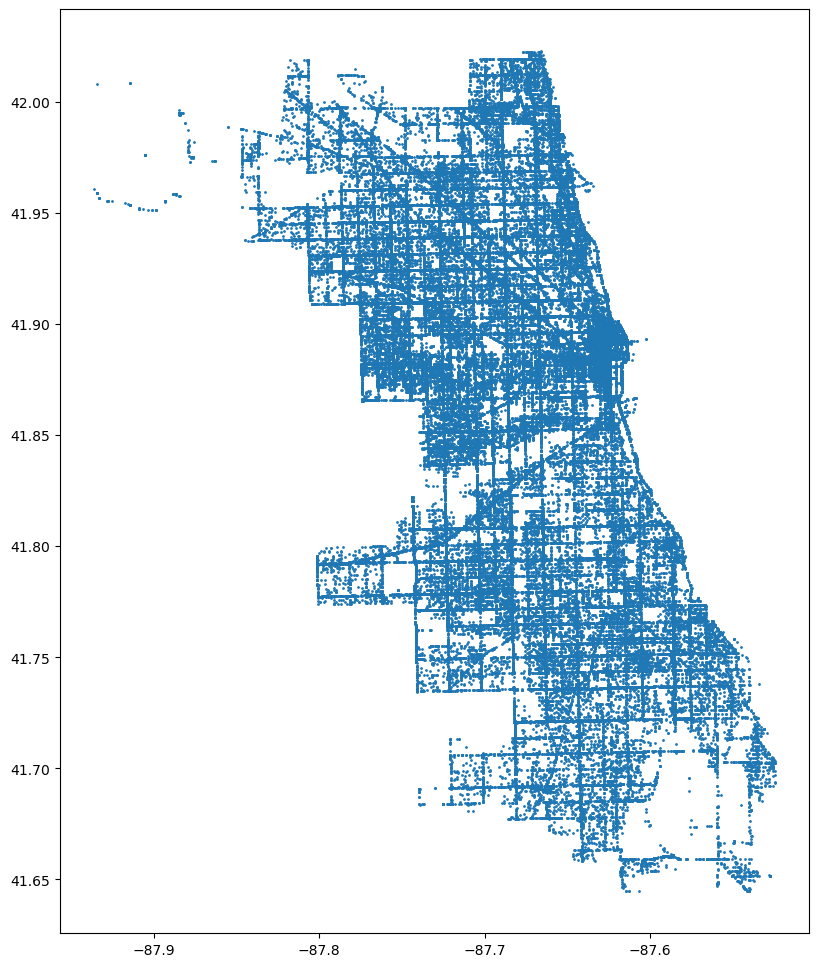

In [5]:
#map the crashes
TrafficCrashes.plot(markersize=1, figsize=(14,12))

In [6]:
#based on the map above, we are not able to conclude much. Visually, we can see areas of higher density, but it is not insightful.

In [7]:
#in order to see which areas have more crashes, we add the shapefile with ward boundaries
WardBoundaries = 'WardBoundaries.shp'
if os.path.exists(WardBoundaries):
    print('Ward Boundaries:', WardBoundaries)
else:
    print('Please download the tutorial data or fix the path!')

Ward Boundaries: WardBoundaries.shp


In [10]:
#read file
WardBoundaries = geopandas.read_file(r"WardBoundaries.shp")

In [11]:
#review the data based on shape area. The wards are all different sizes, so this will affect our results.
#A ward with a larger geographic area is likely to have more crashes, but that does not mean the frequency of crashes is worse.

<Axes: >

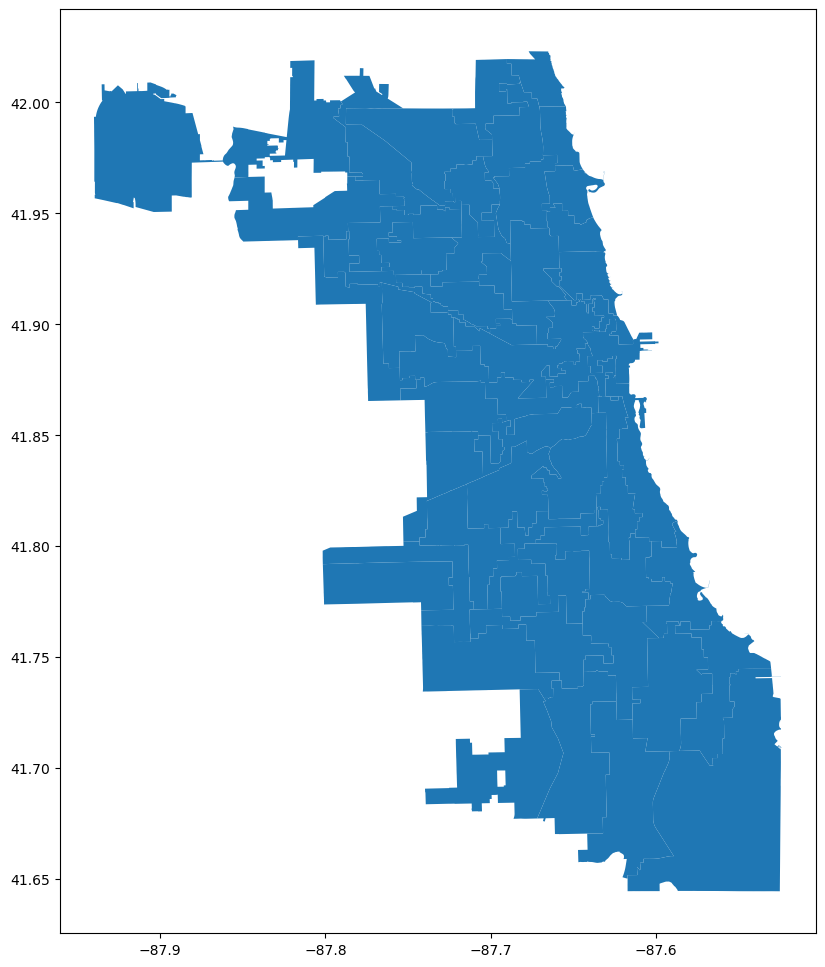

In [12]:
#map the wards. Based on my previous knowledge of Chicago, ward size is mainly based on population.
#ward shape is very irregular
WardBoundaries.plot(figsize=(14,12))

In [13]:
#join ward to crashes so we can see what ward every crash is within
crashes_by_ward=geopandas.sjoin(TrafficCrashes,WardBoundaries[['ward','geometry']].copy(),predicate='within')

In [18]:
#view a summary of how many crashes are in each ward and sort descending by crash number.
counts_per_ward=crashes_by_ward.groupby('ward',as_index=False).size()
counts_per_ward.rename(columns={"size":"number_of_crashes"},inplace=True)
sortedcounts_per_ward = counts_per_ward.sort_values(by='number_of_crashes',axis=0, ascending=False)
sortedcounts_per_ward.head()

ward  number_of_crashes
27  28.0               4611
26  27.0               4334
41  42.0               3886
5    6.0               3181
20  21.0               3146

<b>These results are very interesting. I took a look at the detailed maps of each ward ( https://www.chicago.gov/city/en/depts/dgs/supp_info/ward_maps.html ) and noticed that the top 3, which were far above the other wards, each contained large portions of the Eisenhower highway (I-290), Kennedy highway (I-90), and Dusable Lakeshore Drive (DLSD). In comparison, the bottom three wards are geographically smaller due to higher density of population and only 2 of the 3 had portions of DLSD, and they are typically not as congested sections.</b>

In [19]:
#add this summary to the ward data so we have a simiplified file that lists the number of crashes in each ward with the ward shapefile information.
Wards = WardBoundaries.merge(counts_per_ward, on='ward')

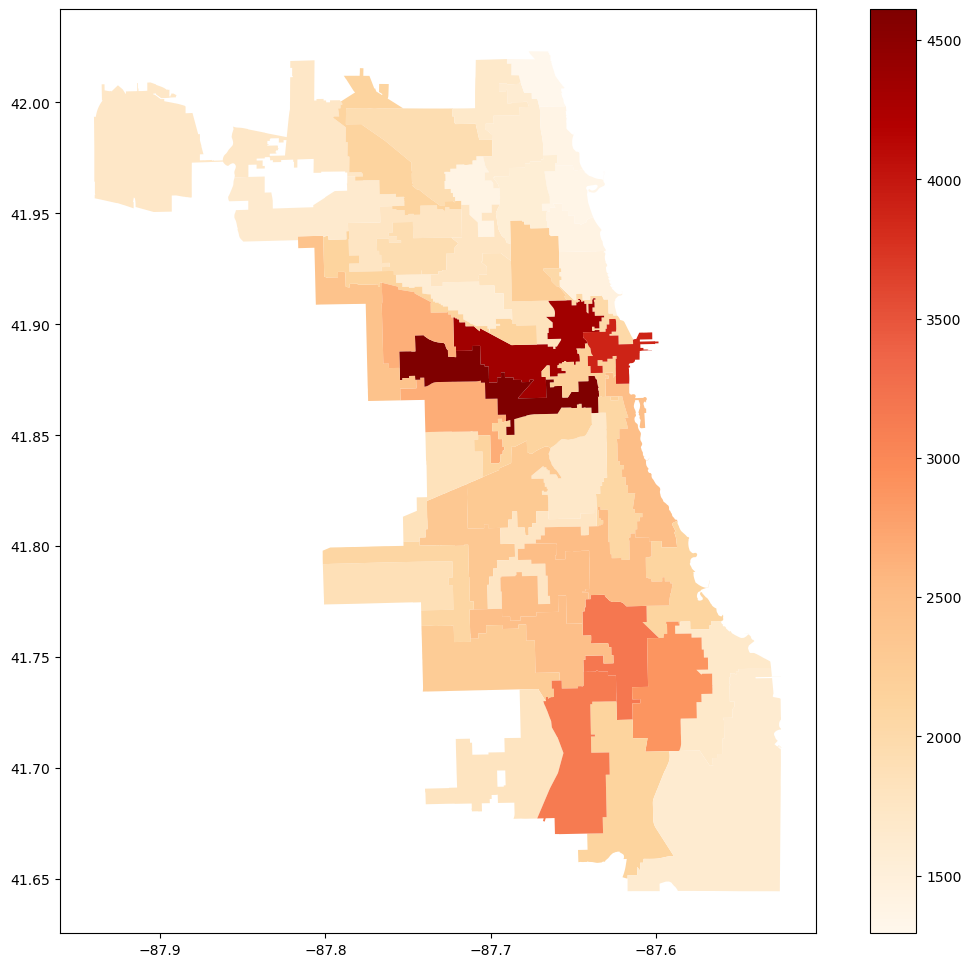

In [31]:
#plot the data as a choropleth map to show the range of crashes and where there are the most.
ax=Wards.plot(column='number_of_crashes', figsize=(14,12),cmap='OrRd', legend=True)

In [27]:
#The issue here is that the wards are all different sizes and we cannot exactly compare them one for one. 
#I am interested in this comparison to know density of crashes and be able to target wards that need political intervention.
#I will add a column that normalizes the crashes by area
#area is measured in square feet
Wards["crashes_per_area"]=Wards["number_of_crashes"] / Wards["st_area_sh"]

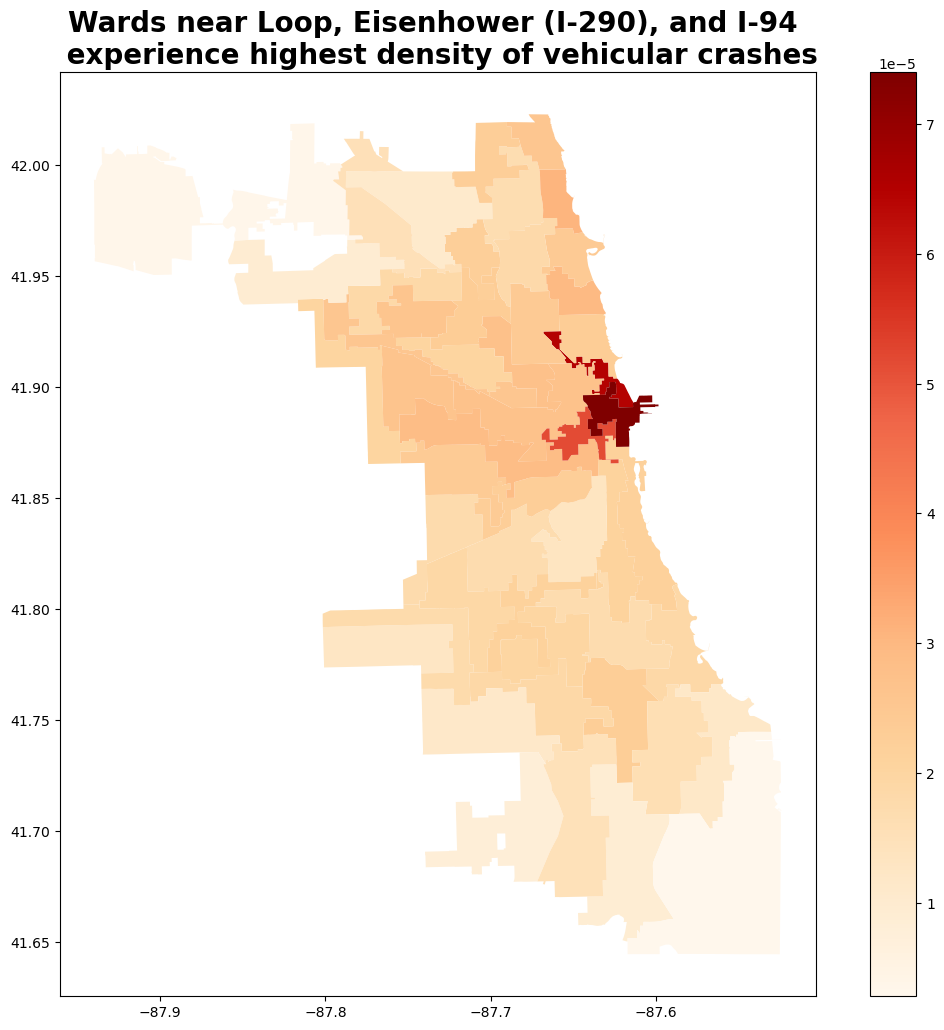

In [40]:
#add more details to the map.
f, ax = plt.subplots(1, figsize=(14,12))
ax = Wards.plot(column='crashes_per_area', cmap='OrRd', legend=True, ax=ax)
ax.set_title('Wards near Loop, Eisenhower (I-290), and I-94 \n experience highest density of vehicular crashes', weight='black', size=20)
plt.show()

In [41]:
#Now that we know what wards in Chicago have the most crashes, we can look into one of the tactics the city implements to improve safety and decrease crashes. 
#This tactic is the implementation of speed cameras.
SpeedCam = 'Speed_Camera_Locations.csv'
if os.path.exists(SpeedCam):
    print('SpeedCam:', SpeedCam)
else:
    print('Please download the tutorial data or fix the path!')

SpeedCam: Speed_Camera_Locations.csv


In [42]:
#read file and check coordinate system
SpeedCam1 = geopandas.read_file(SpeedCam)
crs = {'init':'epsg:4326'}
#since this file was a csv, I need to convert the latitude and longitude data to be recognized geospatially. I do this with a geodataframe and the geopandas library.
#the file has a latitude and a longitude column that I can utilize to add a geometry column. I ensure that the coordinate system selected will match the rest of my data.
gspeedcam = geopandas.GeoDataFrame(
    SpeedCam1, geometry=geopandas.points_from_xy(SpeedCam1.LONGITUDE, SpeedCam1.LATITUDE), crs="EPSG:4326")

In [43]:
#We are going to join the speed camera location data with the ward boundaries data to see what ward each camera is located in.
Speedcam_crashes_by_ward=geopandas.sjoin(gspeedcam,WardBoundaries[['ward','geometry']].copy(),predicate='within')

In [44]:
#Looks like some of the speed cameras go-live date was after 2022. We will need to get rid of those since our crash date is for 2022.
#In order to filter by date we have to convert the column from an object to a date field.
Speedcam_crashes_by_ward["GO-LIVE DATE"]=pd.to_datetime(Speedcam_crashes_by_ward["GO-LIVE DATE"])
#We want to get rid of any cameras that were placed in 2022 or after because the crash data is only for 2022 and we want to look at the effects of the cameras that were there for the entire year.
Speedcam_crashes_by_ward=Speedcam_crashes_by_ward[(Speedcam_crashes_by_ward['GO-LIVE DATE'] < '2022-01-01')]
#This removed 15 rows! These speed cameras were likely in different locations before 2022 and could have an effect on the results.

<Axes: >

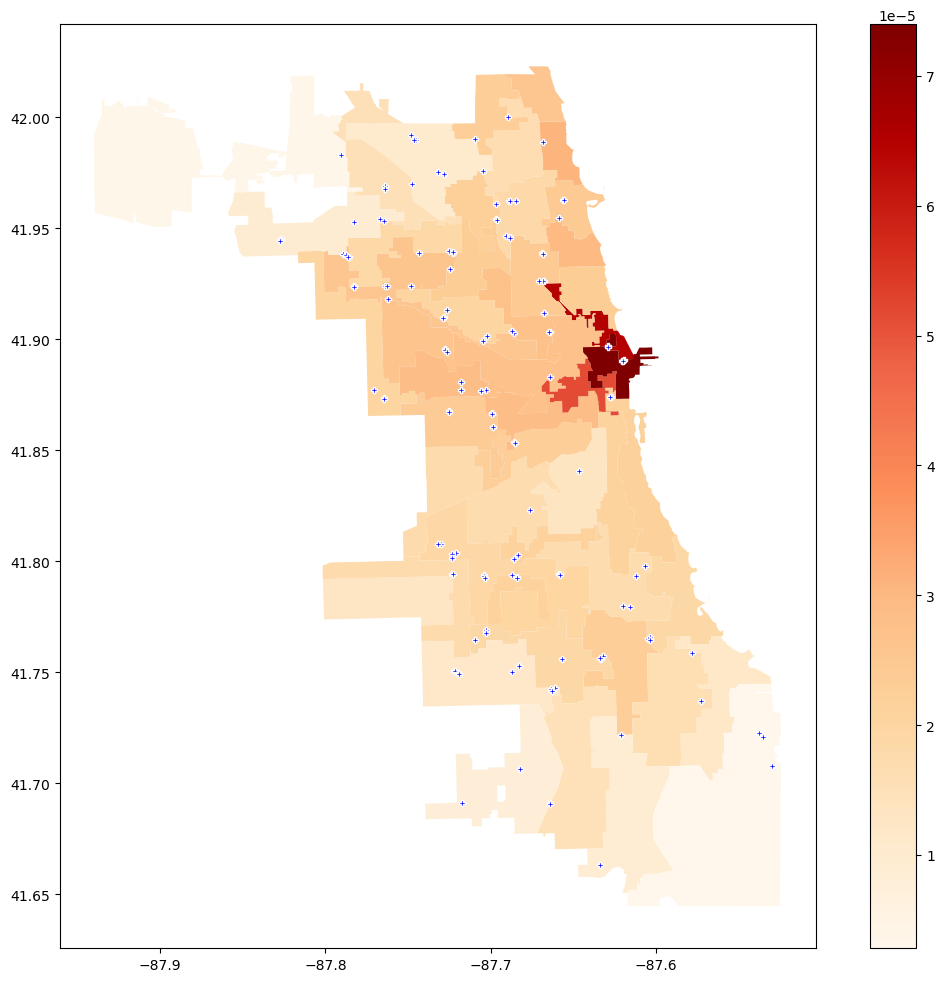

In [44]:
#Map the speed cameras and utilize the crash choropleth map as a basemap. This will help me see if speed cameras are located in areas with more crashes.
base=Wards.plot(figsize=(14,12), column='crashes_per_area', cmap='OrRd', linewidth=2, legend=True)
Speedcam_crashes_by_ward.plot(ax=base,figsize=(14,12),marker='P', color='blue', markersize=20, edgecolor='ghostwhite')

In [46]:
#We are now going to summarize this data to see how many speed cameras are in each ward and sort descending by number of cameras.
Wards.ward = Wards.ward.astype('float64').astype(str)
speedcam_counts_per_ward=Speedcam_crashes_by_ward.groupby('ward',as_index=False).size()
speedcam_counts_per_ward.rename(columns={"size":"cameras"},inplace=True)
speedcam_counts_per_ward.ward = speedcam_counts_per_ward.ward.astype('float64').astype(str)

In [47]:
#join this summarized data with the Wards data so we can compare side by side. Replace NAN with zero (0) for wards without any cameras.
Wards=Wards.merge(speedcam_counts_per_ward, on='ward', how='left')
Wards=Wards.fillna(0)

In [48]:
speedcammean=Wards["cameras"].mean()
speedcammedian =Wards["cameras"].median()
print("The average ward has %s speed cameras. The median number of speed cameras is %s" % (speedcammean, speedcammedian))

The average ward has 2.92 speed cameras. The median number of speed cameras is 2.0


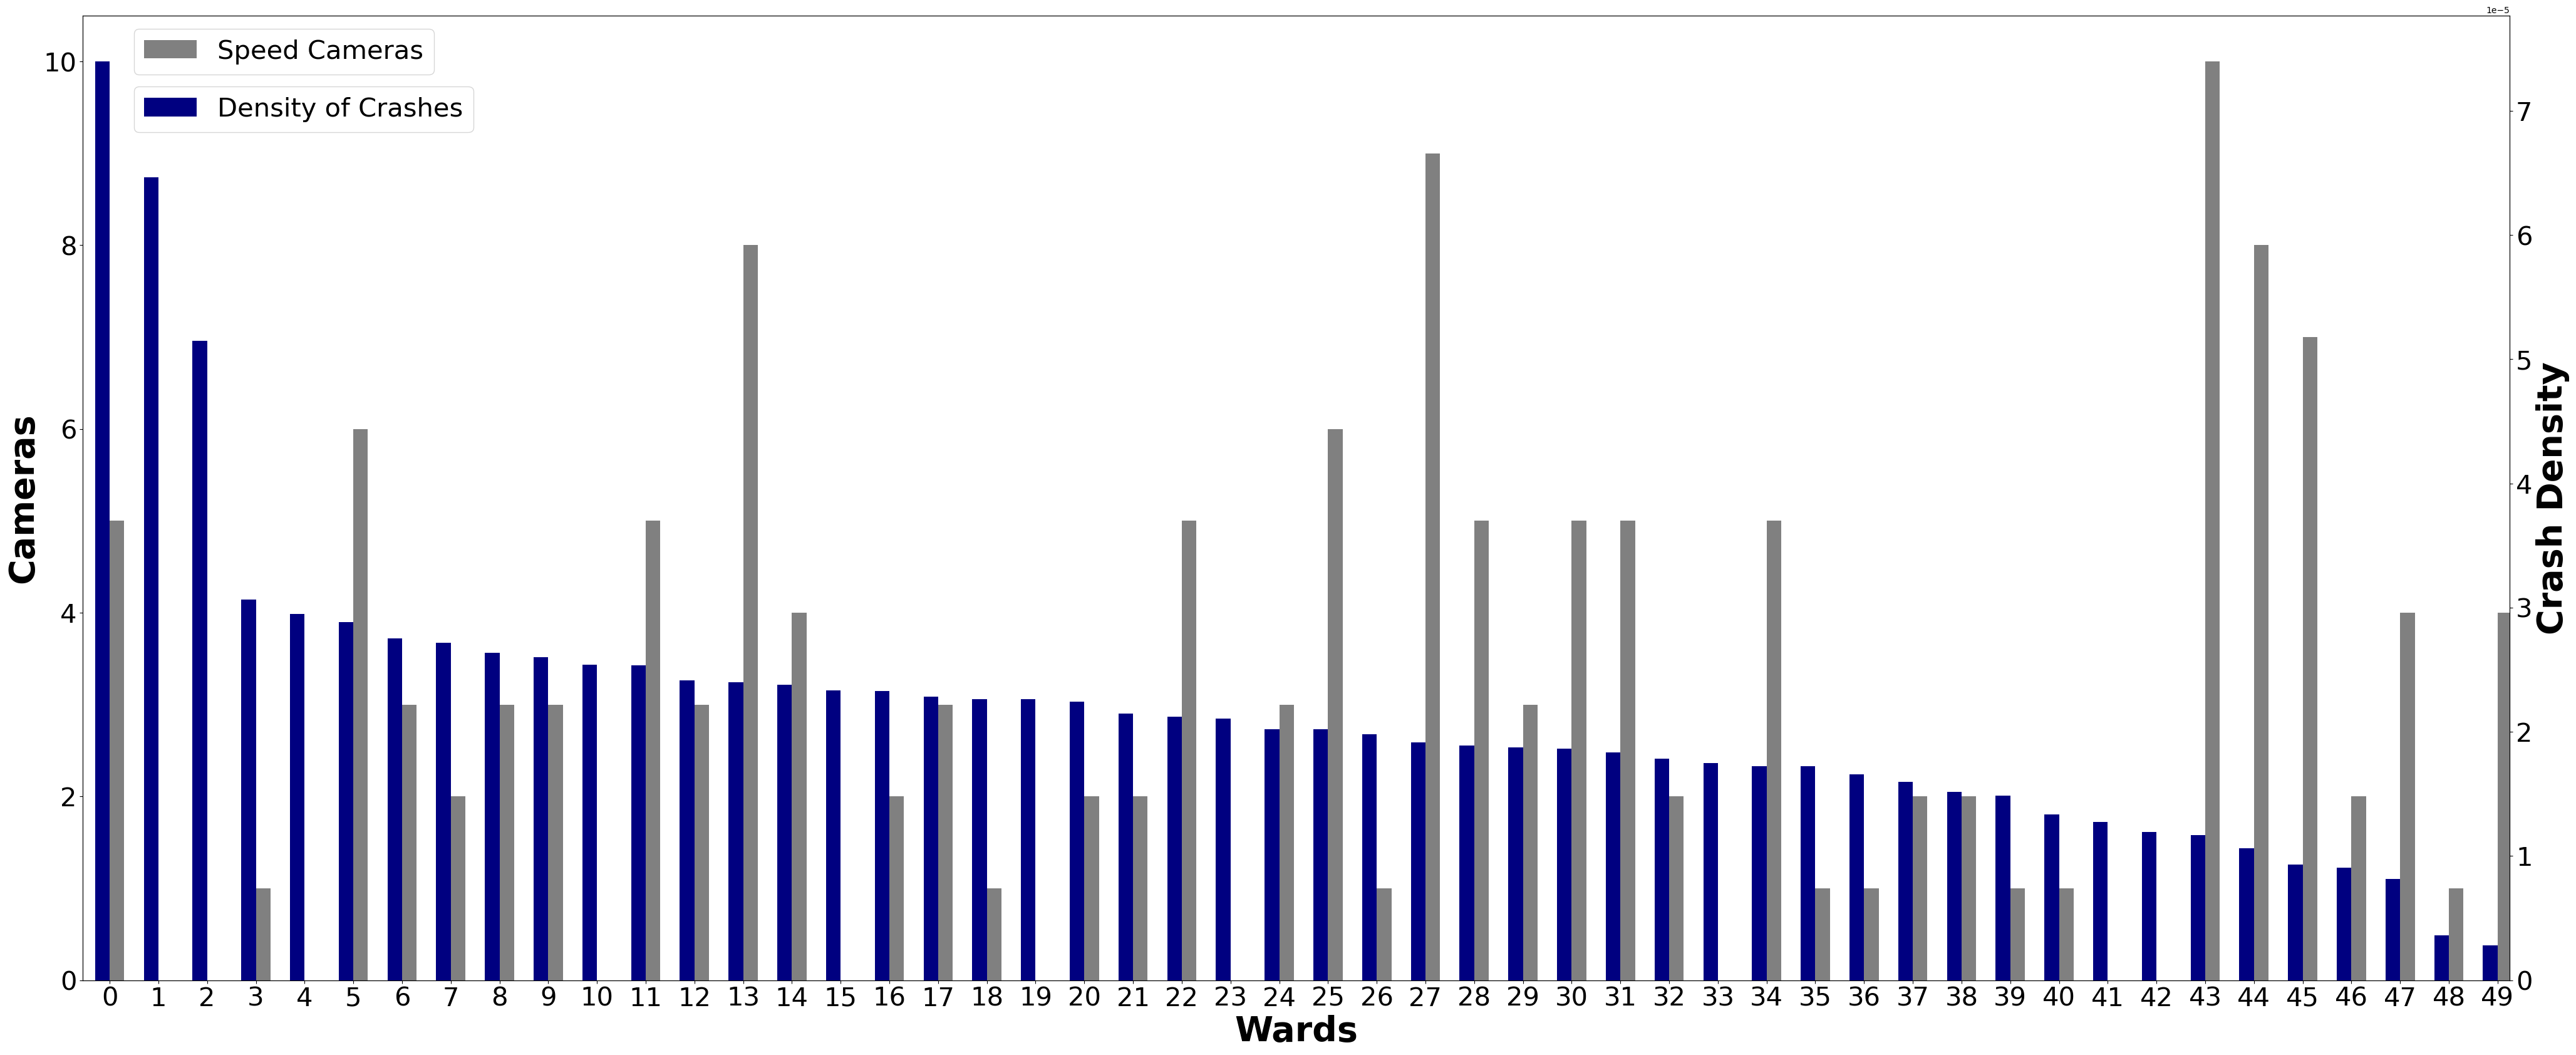

In [49]:
#Graphing the data to see the numbers side by side for each ward.
import numpy as np
import matplotlib.patches as mpatches

WardsChart=Wards.sort_values(['crashes_per_area'], ascending=False)

ax1=WardsChart.plot(x="ward", y="cameras", kind="bar",color='grey',position=0, width=0.3)
ax2 = WardsChart['crashes_per_area'].plot(secondary_y=True, color='navy',figsize=(50,20),kind='bar',position=1,width=0.3)
ax1.set_xlabel('Wards', fontdict={'fontsize': 40, 'fontweight': 'bold'})
ax1.set_ylabel('Cameras',fontdict={'fontsize': 40, 'fontweight': 'bold'})
ax2.set_ylabel('Crash Density',fontdict={'fontsize': 40, 'fontweight': 'bold'})
ax1.tick_params(axis='both',labelsize=30)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 0)
ax2.tick_params(axis='both',labelsize=30)

ax1.legend(['Speed Cameras'],fontsize=30, loc='best', bbox_to_anchor=(0.15, 1))
plt.legend(['Density of Crashes'],fontsize=30, bbox_to_anchor=(0.0156, .94))

plt.show()

<b>Most wards have at least one (1) speed camera, and ten (10) do not (not shown in the list above due to how I joined the data). These ten (10) most likely did have speed cameras at some point during 2022, but moved locations since.
    Ward 18 is the sixth largest (geographically) ward, so it is not extremely surprising to see it having more speed cameras, but, it has the most at ten (10). Of the top ten (10) wards with the most cameras, none are in the top ten (10) geographically largest wards. Of the bottom ten (10) wards for cameras, two (2) are in the bottom ten (10) geograaphical sized wards. 
    Looking at crashes, one ward in the top five (5) for speed cameras is in the bottom ten (10) for crashes, and no wards with zero (0) cameras are in the top ten (10) for crashes. It is important to note that speed cameras are not on highways so wards where the majority of crashes occur on highways are not helped by the current placement of speed cameras.</b>

<b>Looking at crash density, three (3) of the top ten (10) wards for highest density of crashes have zero (0) speed cameras. Only two (2) wards in the bottom ten (10) for crash density are also in the top ten (10) for speed cameras.
    It is important to think about the difference in number of cameras. The lowest amount is zero (0) and the highest is ten (10). This is a big range.
    Overall, this analysis is inconclusive on its own and will need further investigation.</b>

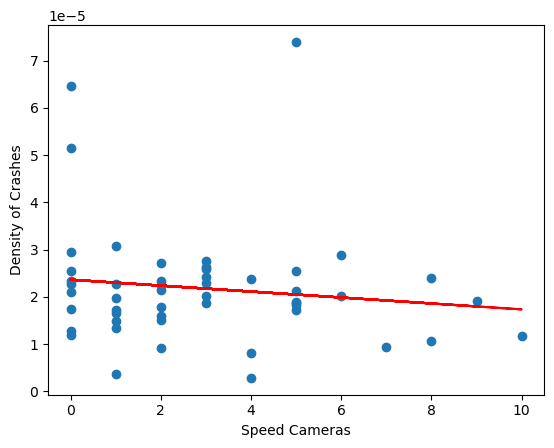

In [50]:
#Analyzing the relationship between the two variables
x=Wards.cameras
y=Wards.crashes_per_area

plt.scatter(x,y)

z=np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r")
plt.xlabel("Speed Cameras")
plt.ylabel("Density of Crashes")

plt.show()

In [54]:
#The chart above shows a very small relationship. Finding the correlation between the variables will help me understand how strong this is.

#Finding the covariance
covariance = np.cov(x, y)
print(covariance)

#Finding Pearson's correlation p-value
from scipy.stats import pearsonr
corr, _ = pearsonr(x,y)
print('Pearsons correlation: %.3f' % corr)

#Finding Spearmans correlation p-value, which is helpful for understanding nonlinear relationships
from scipy.stats import spearmanr
corr, _ = spearmanr(x, y)
print('Spearmans correlation: %.3f' % corr)

[[ 6.72816327e+00 -4.23426976e-06]
 [-4.23426976e-06  1.57822963e-10]]
Pearsons correlation: -0.130
Spearmans correlation: -0.104


In [55]:
#There is a very small, negative correlation between the variables. This is negligible correlation. Thus, the relationship of this data is statistically insignificant.
#let's see if this changes when we only look at speed related crashes.

<Axes: >

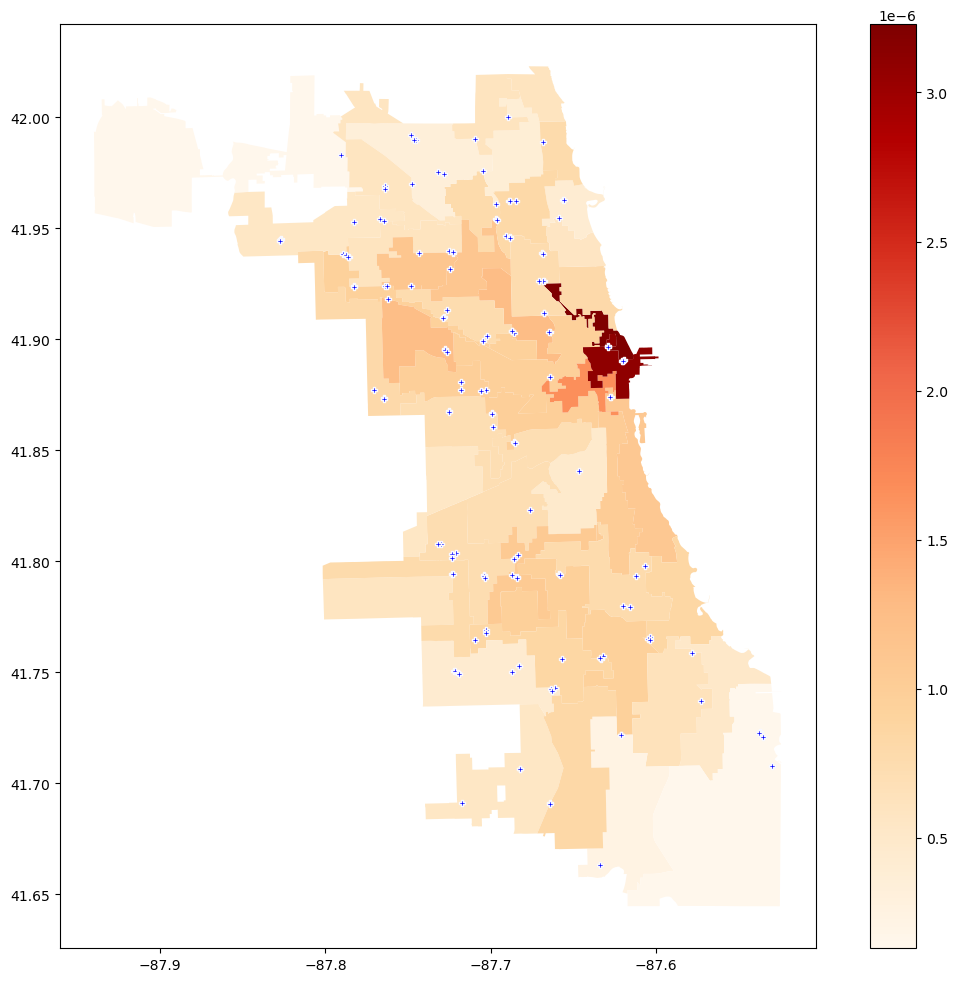

In [56]:
SpeedCrashes = TrafficCrashes[(TrafficCrashes['prim_contr']=='EXCEEDING SAFE SPEED FOR CONDITIONS') | (TrafficCrashes['prim_contr']=='FAILING TO REDUCE SPEED TO AVOID CRASH')]

speedcrashes_by_ward=geopandas.sjoin(SpeedCrashes,WardBoundaries[['ward','geometry']].copy(),predicate='within')
speedcounts_per_ward=speedcrashes_by_ward.groupby('ward',as_index=False).size()
speedcounts_per_ward.rename(columns={"size":"number_of_speedcrashes"},inplace=True)
speedcounts_per_ward.sort_values(by='number_of_speedcrashes',axis=0, ascending=False)
speedWards = WardBoundaries.merge(speedcounts_per_ward, on='ward')
speedWards["speedcrashes_per_area"]=speedWards["number_of_speedcrashes"] / speedWards["st_area_sh"]
speedWards.ward = speedWards.ward.astype('float64').astype(str)
speedWards=speedWards.merge(speedcam_counts_per_ward, on='ward',how='left')
speedWards=speedWards.fillna(0)

base=speedWards.plot(figsize=(14,12), column='speedcrashes_per_area', cmap='OrRd', linewidth=2, legend=True)
Speedcam_crashes_by_ward.plot(ax=base,figsize=(14,12),marker='P', color='blue', markersize=20, edgecolor='ghostwhite')

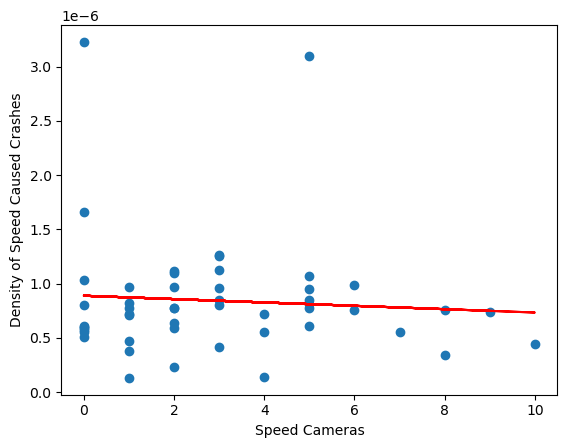

In [57]:
x1=speedWards.cameras
y1=speedWards.speedcrashes_per_area

plt.scatter(x1,y1)

z1=np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
plt.plot(x1,p1(x1),"r")
plt.xlabel("Speed Cameras")
plt.ylabel("Density of Speed Caused Crashes")

plt.savefig('SpeedCausedCrashCorrelation.png',dpi=300)
plt.show()

In [58]:
#Finding the covariance
covariance1 = np.cov(x1, y1)
print(covariance1)

#Finding Pearson's correlation p-value
corr1, _ = pearsonr(x1,y1)
print('Pearsons correlation: %.3f' % corr1)

#Finding Spearmans correlation p-value, which is helpful for understanding nonlinear relationships
corr1, _ = spearmanr(x1, y1)
print('Spearmans correlation: %.3f' % corr1)

[[ 6.72816327e+00 -1.04108586e-07]
 [-1.04108586e-07  3.14422055e-13]]
Pearsons correlation: -0.072
Spearmans correlation: 0.037


In [58]:
#The p-value changes, but is still insignificant. 
#Analyzing this data by ward could be problematic, but is still important since alderman have control over a lot of traffic changes in their wards.

<b>With my previous methods of mapping, it is still too difficult to see the details of this data. Below, I begin to use folium so I can interact with the map and gain more insights.</b>

In [59]:
#additional libraries need to be imported for this method.
#I will similarily utilize the choropleth map as the first map layer and plot the speed camera locations on top.
#The main benefits of this method is that I can interact with the map, zoom in and out, and use a basemap that have detailed street geography.
#This makes it easier for me to look at street intersections, highway locations, parks, etc.

import json
import folium

#we must convert the date column to a string because a date field cannot be converted to geojson
Speedcam_crashes_by_ward['GO-LIVE DATE']=Speedcam_crashes_by_ward['GO-LIVE DATE'].astype(str)

speedcam_gjson = folium.features.GeoJson(Speedcam_crashes_by_ward, 
                                         name = "Speed Camera Locations",
                                        marker=folium.CircleMarker(radius=7,fill_color="grey", fill_opacity=0.7, color="black",weight=3),
                                        tooltip=folium.GeoJsonTooltip(fields=['ADDRESS','GO-LIVE DATE','FIRST APPROACH','SECOND APPROACH','ward']))

fmap = folium.Map(location=[41.8,-87.6], zoom_start=11)

folium.Choropleth(
    geo_data= Wards,
    name="choropleth",
    data=Wards,
    columns = ["ward", "crashes_per_area"],
    key_on="feature.properties.ward",
    fill_color="YlOrBr",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Crash Density",).add_to(fmap)

speedcam_gjson.add_to(fmap)
folium.LayerControl().add_to(fmap)

fmap

In [60]:
#Taking this method a step further, I decide to get rid of the ward boundaires and look specifically as concentrated ares of crashes.
#In order to do this, I will utilize a folium plug in that takes point data (crash data in my map) and transforms it into a heat map.
#I plot the speed cameras on top.
#Now, I am able to look at the speed camera locations and determine if there are concentrations of crashes nearby.
#This type of map can also be important for determining locations for new speed cameras to improve safety.

from folium import plugins

heatmap = folium.Map(location = [41.922446, -87.674360], zoom_start=14.8)
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in TrafficCrashes.geometry]
heat_data
speedcam_gjson.add_to(heatmap)
plugins.HeatMap(heat_data).add_to(heatmap)
heatmap.save('heatmap.html')
heatmap

In [61]:
#repeating these steps with the data that only includes speed caused crashes

heatmap2 = folium.Map(location = [41.922446, -87.674360], zoom_start=14.8)
heat_data2 = [[point.xy[1][0], point.xy[0][0]] for point in SpeedCrashes.geometry]
heat_data2
speedcam_gjson.add_to(heatmap2)
plugins.HeatMap(heat_data2).add_to(heatmap2)

heatmap2

<b>Using Folium allows me to investigate certain areas and hotspots.</b>

<b>Zooming in and out of the data allows me to see target areas for intervention.</b>

<b>The map showing only speed related crashes helps show that the speed cameras are effective in preventing certain types of crashes in certain areas.</b>